# Song Recommendations

## Q1(a) 

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below
def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.

    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

   
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark
def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()
 
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()

# Make css changes to improve spark output readability
html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.ui.port,4453
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.driver.extraJavaOptions,-Dderby.system.home=/tmp/ldo61/spark/
spark.sql.shuffle.partitions,32


In [3]:
# Import modules from pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract

# Initialize the SparkSession
spark = SparkSession.builder.appName('Collaborative Filtering').getOrCreate()

# Show the data structure of tasteprofile  
!hdfs dfs -ls /data/msd/tasteprofile/
!hdfs dfs -du -h /data/msd/tasteprofile
!hdfs dfs -ls /data/msd/tasteprofile/mismatches

Found 2 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/tasteprofile/mismatches
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/tasteprofile/triplets.tsv
2.0 M    16.2 M  /data/msd/tasteprofile/mismatches
488.4 M  3.8 G   /data/msd/tasteprofile/triplets.tsv
Found 2 items
-rwxr-xr-x   8 jsw93 supergroup      91342 2021-09-29 10:35 /data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt
-rwxr-xr-x   8 jsw93 supergroup    2026182 2021-09-29 10:35 /data/msd/tasteprofile/mismatches/sid_mismatches.txt


In [4]:
# Count the number of row for tasteprofile-mismatches
taste_mismatches_df = (
    spark.read.format('com.databricks.spark.csv')
    .option('header', 'false')
    .option('inferSchema', 'true')
    .load('hdfs:///data/msd/tasteprofile/mismatches/*.txt')
)
taste_mismatches_df.show(10, truncate=False)

# Extract song_id and creat a new dataframe
new_mismatches_df = taste_mismatches_df.select(
    regexp_extract('_c0', r'<(\w+) (\w+)>', 1).alias('song_id'),
    regexp_extract('_c0', r'<\w+ (\w+)>', 1).alias('track_id'),
    regexp_extract('_c0', r'> (.+?) - (.+?) !=', 1).alias('artist1_id'),
    regexp_extract('_c0', r'> (.+?) - (.+?) !=', 2).alias('title1_id'),
    regexp_extract('_c0', r'!= (.+?) - (.+?)$', 1).alias('artist2_id'),
    regexp_extract('_c0', r'!= (.+?) - (.+?)$', 2).alias('title2_id')
)
new_mismatches_df.show(10, truncate=False)

new_mismatches_rows = new_mismatches_df.count()
print(new_mismatches_rows)

+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|_c0                                                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10> Digital Underground  -  The Way We Swing  !=  Linkwood  -  Whats up with the Underground              |
|ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1> Jimmy Reed  -  The Sun Is Shining (Digitally Remastered)  !=  Slim Harpo  -  I Got Love If You Want It|
|ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E> Africa HiTech  -  Footstep  !=  Marcus Worgull  -  Drumstern (BONUS TRACK)                            |
|ERROR: <SONGHTM12A8C1374EF TRMMITP128F425D8D0> Death in Vegas  -  Anita Berber  !=  Val

In [5]:
# Count the number of row for tasteprofile-triplets
taste_triplets_df = (
    spark.read.format('com.databricks.spark.csv')
    .option('header', 'false')
    .option('inferSchema', 'true')
    .option('sep', '\t')
    .load('hdfs:///data/msd/tasteprofile/triplets.tsv')
    .toDF('user_id', 'song_id', 'play_count')
)

taste_triplets_df.show(10, truncate=False)

taste_triplets_rows = taste_triplets_df.count()
print(taste_triplets_rows)

+----------------------------------------+------------------+----------+
|user_id                                 |song_id           |play_count|
+----------------------------------------+------------------+----------+
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQEFDN12AB017C52B|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQOIUJ12A6701DAA7|2         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQOKKD12A6701F92E|4         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSDVHO12AB01882C7|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSKICX12A6701F932|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSNUPV12A8C13939B|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSVMII12A6701F92D|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTUNHI12B0B80AFE2|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTXLTZ12AB017C535|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTZDDX12A6701F935|1         |
+----------------------------------------+---------

In [6]:
# Check the current partitions
mismatches_partitions = new_mismatches_df.rdd.getNumPartitions()
triplets_partitions = taste_triplets_df.rdd.getNumPartitions()

print(mismatches_partitions)
print(triplets_partitions)

2
8


In [7]:
# Set an ideal number of records per partition
records_per_partition = 100000

# Calculate the new number of partitions
new_triplets_partitions = max(1, taste_triplets_rows // records_per_partition)

print(new_triplets_partitions)

483


In [8]:
# Cache the dataframes
new_mismatches_df.cache()
taste_triplets_df.cache()

DataFrame[user_id: string, song_id: string, play_count: int]

In [9]:
# Verify caching
new_mismatches_count = new_mismatches_df.count()
taste_triplets_count = taste_triplets_df.count()

print(new_mismatches_count)
print(taste_triplets_count)

20032
48373586


## Q1(b) 

In [10]:
# Calculate unique songs and users
unique_songs = taste_triplets_df.select('song_id').distinct().count()
unique_users = taste_triplets_df.select('user_id').distinct().count()

print(unique_songs)
print(unique_users)

384546
1019318


## Q1(c)

In [11]:
# Find the most active user and their song count
most_active_user = taste_triplets_df.groupBy('user_id').count().orderBy('count', ascending=False).first()
songs_active_user = taste_triplets_df.filter(taste_triplets_df.user_id == most_active_user['user_id']).select('song_id').distinct().count()
num_songs = unique_songs

percent = (songs_active_user / num_songs) * 100

print(songs_active_user)
print(f'{percent:.2f}%')

4400
1.14%


## Q1(d)

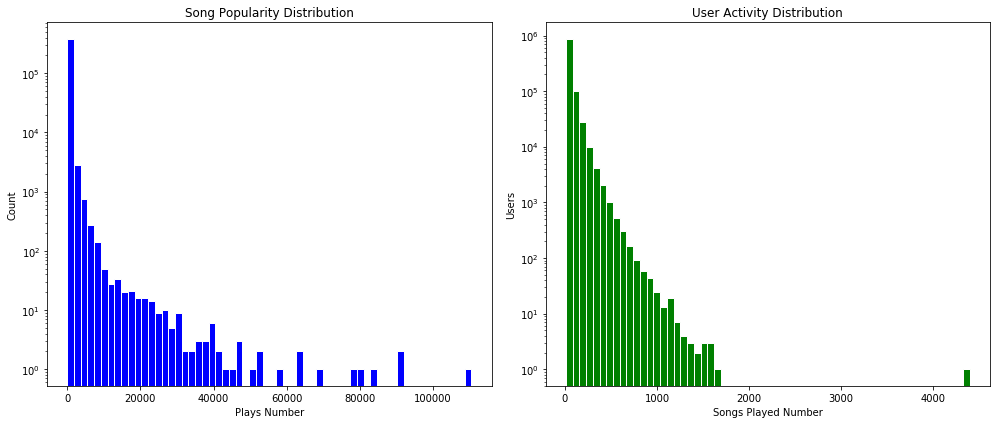

In [13]:
# Import modules from pyspark
import matplotlib.pyplot as plt

# Collect user plays per song
song_play_counts = taste_triplets_df.groupBy('song_id').count().orderBy('count', ascending=False).collect()
song_play_counts = [row['count'] for row in song_play_counts]

# Collect song plays per user
user_play_counts = taste_triplets_df.groupBy('user_id').count().orderBy('count', ascending=False).collect()
user_play_counts = [row['count'] for row in user_play_counts]

# Plot the distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(song_play_counts, bins=60, log=True, color='blue', edgecolor='white')
plt.title('Song Popularity Distribution')
plt.xlabel('Plays Number')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(user_play_counts, bins=60, log=True, color='green', edgecolor='white')
plt.title('User Activity Distribution')
plt.xlabel('Songs Played Number')
plt.ylabel('Users')

plt.tight_layout()
plt.show()

## Q2(a)

In [14]:
# Import modules from pyspark
from pyspark.sql.functions import col, count

# Collect user plays per song
song_play_counts = taste_triplets_df.groupBy('song_id').agg(count('play_count').alias('count'))

# Collect song plays per user
user_play_counts = taste_triplets_df.groupBy('user_id').agg(count('play_count').alias('count'))

# Show the results
song_play_counts.describe().show()
user_play_counts.describe().show()

+-------+------------------+------------------+
|summary|           song_id|             count|
+-------+------------------+------------------+
|  count|            384546|            384546|
|   mean|              null|125.79401684063805|
| stddev|              null| 799.0258343095946|
|    min|SOAAADD12AB018A9DD|                 1|
|    max|SOZZZWN12AF72A1E29|            110479|
+-------+------------------+------------------+

+-------+--------------------+-----------------+
|summary|             user_id|            count|
+-------+--------------------+-----------------+
|  count|             1019318|          1019318|
|   mean|                null|47.45681524313316|
| stddev|                null|57.81573063001365|
|    min|00000b72200188206...|               10|
|    max|fffff9534445f481b...|             4400|
+-------+--------------------+-----------------+



In [15]:
from pyspark.sql.functions import expr
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Group data by song and user and count occurrences
song_play_counts = taste_triplets_df.groupBy('song_id').agg(count('play_count').alias('count'))
user_play_counts = taste_triplets_df.groupBy('user_id').agg(count('play_count').alias('count'))

# Define a window specification
windowSpec = Window.orderBy("count")

# Add a cumulative count column 
song_play_counts = song_play_counts.withColumn("cumulative_count", F.sum('count').over(windowSpec))
user_play_counts = user_play_counts.withColumn("cumulative_count", F.sum('count').over(windowSpec))

# Calculate the total number
total_songs = song_play_counts.count()
total_users = user_play_counts.count()

# Determine the median index 
median_index_song = (total_songs + 1) // 2
median_index_user = (total_users + 1) // 2

# Retrieve the median value
median_song = song_play_counts.where(song_play_counts.cumulative_count >= median_index_song).select("count").first()
median_user = user_play_counts.where(user_play_counts.cumulative_count >= median_index_user).select("count").first()

# Output the median play counts
print(median_song['count'])
print(median_user['count'])

4
11


In [16]:
# Import modules from pyspark
from pyspark.sql.functions import col

# Choose thresholds for N and M
N = 10
M = 20

# Remove data fewer than thresholds
filtered_songs = song_play_counts.filter(col('count') >= N).select('song_id')
filtered_users = user_play_counts.filter(col('count') >= M).select('user_id')

# Generate the filtered dataset
filtered_data = taste_triplets_df.join(filtered_songs, on='song_id').join(filtered_users, on='user_id')
filtered_data = filtered_data.filter(col("user_id").isNotNull() & col("song_id").isNotNull())
filtered_data.select('play_count').describe().show()
filtered_data.cache()

filtered_data_count = filtered_data.count()
print(filtered_data_count)

+-------+-----------------+
|summary|       play_count|
+-------+-----------------+
|  count|         42806354|
|   mean|2.831213188584106|
| stddev|6.255794607011777|
|    min|                1|
|    max|             9667|
+-------+-----------------+

42806354


## Q2(b)

In [17]:
# Import modules from pyspark
from pyspark.sql.functions import col, rand, row_number, max as F_max
from pyspark.sql.window import Window

# Split the dataset
filtered_data = filtered_data.withColumn("random", rand())
window_spec = Window.partitionBy("user_id").orderBy("random")
filtered_data = filtered_data.withColumn("rank", row_number().over(window_spec))

# Ensure at least 25% plays in the test set
user_play_counts = filtered_data.groupBy("user_id").agg(F_max("rank").alias("max_rank"))
filtered_data = filtered_data.join(user_play_counts, on="user_id")
filtered_data = filtered_data.drop(user_play_counts["max_rank"])

# After dropping the duplicate max_rank column, proceed with filtering
test_data = filtered_data.filter(col("rank") <= col("max_rank") * 0.25)
train_data = filtered_data.filter(col("rank") > col("max_rank") * 0.25)

# Ensure each user in test set has plays in train set
train_users = train_data.select('user_id').distinct()
test_data = test_data.join(train_users, on='user_id')

# Drop intermediate columns and cache
train_data = train_data.drop("random", "rank", "max_rank").cache()
test_data = test_data.drop("random", "rank", "max_rank").cache()

# Print the results
print(train_data.count())
print(test_data.count())

32346198
10460156


## Q2(c)

In [19]:
# Import necessary modules
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Convert user_id and song_id to numeric
user_indexer = StringIndexer(inputCol="user_id", outputCol="userIndex")
song_indexer = StringIndexer(inputCol="song_id", outputCol="songIndex")

indexed_train_data = user_indexer.fit(train_data).transform(train_data)
indexed_train_data = song_indexer.fit(indexed_train_data).transform(indexed_train_data)

indexed_test_data = user_indexer.fit(test_data).transform(test_data)
indexed_test_data = song_indexer.fit(indexed_test_data).transform(indexed_test_data)

# Initialize ALS model
als = ALS(
    userCol="userIndex",
    itemCol="songIndex",
    ratingCol="play_count",
    implicitPrefs=True,
    maxIter=10,
    regParam=0.1
)

# Train ALS model
als_model = als.fit(indexed_train_data)

# Evaluate the model on training data
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="play_count",
    predictionCol="prediction"
)

# Evaluate the model on test data
test_predictions = als_model.transform(indexed_test_data)
test_rmse = evaluator.evaluate(test_predictions)

# Print the results
print(test_rmse)

7.3497043615298985


## Q2(d)

In [19]:
# Randomly select users from test set
seed = 123
selected_users = test_data.select('user_id').distinct().orderBy(rand(seed)).limit(5)
selected_users.show(truncate=False)

# Convert to indexed user ID
selected_users_id = [row['user_id'] for row in selected_users.collect()]
indexed_user_indexer = user_indexer.fit(test_data)
indexed_selected_users = indexed_user_indexer.transform(selected_users)

# Generate recommendations
user_recs = als_model.recommendForUserSubset(indexed_selected_users, 10)
user_recs.show(truncate=False)

# Convert songIndex to song_id
indexed_song_indexer = song_indexer.fit(test_data)
song_index_mappings = indexed_song_indexer.labels

# Get the actual songs
actual_played_songs = indexed_test_data.filter(indexed_test_data.user_id.isin(selected_users_id)).select('user_id', 'song_id')
actual_played_songs.show(truncate=False)

# Evaluate the effectiveness
for user_id in selected_users_id:
    print(user_id)
    user_index = indexed_selected_users.filter(col('user_id') == user_id).select('userIndex').collect()[0]['userIndex']
    recommended_songs = user_recs.filter(col('userIndex') == user_index).select('recommendations').collect()[0][0]
    recommended_songs_id = [song_index_mappings[row.songIndex] for row in recommended_songs]  # Convert songIndex to song_id

    actual_songs = actual_played_songs.filter(col('user_id') == user_id).select('song_id')
    actual_songs_id = [row['song_id'] for row in actual_songs.collect()]

    print(recommended_songs_id)
    print(actual_songs_id)

+----------------------------------------+
|user_id                                 |
+----------------------------------------+
|acfa5a7d8b7751c0dc7e3f3cbc942aa0a190e177|
|7f7eb18092db97abe9aee1d1cb219d0dc593f427|
|29128ed28c46650ece927f008d1be85646674fd9|
|d1e0719db85cc41049ee8ae35eb1eefdbb74a4ca|
|6ec7065ccbb67e7170692c8699dd6d1e378beaf0|
+----------------------------------------+

+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userIndex|recommendations                                                                                                                                                                               |
+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|32

## Q2(e)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.mllib.evaluation import RankingMetrics

# Convert to integer type
indexed_test_data = indexed_test_data.withColumn("userIndex", F.col("userIndex").cast(IntegerType()))
indexed_test_data = indexed_test_data.withColumn("songIndex", F.col("songIndex").cast(IntegerType()))

# Sample 10% of the test data
sample_fraction = 0.1
sampled_data = indexed_test_data.sample(fraction=sample_fraction, seed=123)
print(f'Sampled data count: {sampled_data.count()}')

# Get distinct users from the sampled data
sampled_users = sampled_data.select('userIndex').distinct().withColumn("userIndex", F.col("userIndex").cast(IntegerType()))
print(f'Sampled users count: {sampled_users.count()}')

# Generate recommendations for the sampled users
k = 10
user_recs = als_model.recommendForUserSubset(sampled_users, k)
user_recs = user_recs.withColumn("recommendations", F.expr(f"transform(recommendations, x -> x.songIndex)"))
user_recs = user_recs.withColumn("recommendations", F.col("recommendations").cast(ArrayType(IntegerType())))

# Get actual played songs for the sampled users
actual_played_songs = sampled_data.groupBy('userIndex').agg(F.collect_list('songIndex').alias('actual_songs'))
actual_played_songs = actual_played_songs.withColumn("actual_songs", F.col("actual_songs").cast(ArrayType(IntegerType())))

# Join recommendations with actual played songs
user_recs = user_recs.join(actual_played_songs, on='userIndex')

# Convert to format for RankingMetrics
temp = user_recs.select(
    F.col("userIndex"),
    F.col("recommendations"),
    F.col("actual_songs").alias("relevant")
)
temp.cache()
temp.count() 
temp.printSchema()

# Prepare data for RankingMetrics
pred_and_labels = temp.select(F.col("recommendations"), F.col("relevant")).rdd.map(lambda row: (row[0], row[1]))

# Initialize RankingMetrics
metrics = RankingMetrics(pred_and_labels)

# Compute evaluation metrics
precisionAtK = metrics.precisionAt(k)
ndcgAtK = metrics.ndcgAt(k)
mapAtK = metrics.meanAveragePrecisionAt(k)

# Print the results
print(f'Precision@10: {precisionAtK:.3f}')
print(f'NDCG@10: {ndcgAtK:.3f}')
print(f'MAP@10: {mapAtK:.3f}')

In [ ]:
stop_spark()